In [ ]:
!mkdir -p /scr/emazuh_data && tar xC /scr/emazuh_data -f /gscratch/scrubbed/emazuh/birds/files/ssw60/birds_inat.tar


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../../../HyViT-MoE/')
import optuna
from hpo.objective import objective_general, objective_mlp
from training.logging import log_optuna_importance_to_wandb
from configs.adapter_config import AdapterConfig

/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [6]:
# TODO: Update objective_mlp with best json: save to file as well
study_name = "cvpr_general_hyperparams_birdsmvit"
study_mlp = optuna.create_study(direction="maximize", study_name=study_name)
study_mlp.optimize(
        lambda trial: objective_mlp(
            trial,
            epochs=20,
            model_name="mobilevit",
            dataset_name="birds_inat",
            data_subset=0.25,
            log_wandb=False,
            adapter_cfg=None,
            ds_grad_norm_file='birds_grad_norm_per_layer.csv',
        ),
        n_trials=1
    )

best_hyperparams = study_mlp.best_trial.params
print("Best general hyperparameters:", best_hyperparams)
# importances_acc, best_trial_acc = log_optuna_importance_to_wandb(study_mlp, target_idx=0, study_name=study_name)b

[I 2025-11-19 02:58:43,314] A new study created in memory with name: cvpr_general_hyperparams_birdsmvit


[INFO]: Using dataset data/birds_inat
args Namespace(n_vid_frames=8, n_train_frames=2, visualization=False, double_view_image=False, k_shot=-1, evaluate=False, test=False, log_wandb=True, val_samples_per_class=5, max_grad_norm=10.0, eval_transform=False, num_workers=6, from_custom_pretrained=False, apply_entropy_to_val=True, ds_grad_norm_file=None, data_path='data/birds_inat', data_subset=0.25, vision_model='mobilevit', randerase_p=0.25825040732523524, batch_size=16, classes=60, transform_simple=Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    RandomErasing(p=0.25825040732523524, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=random, inplace=False)
), test_loader=<torch.utils.data.dataloader.DataLoader object at 0x149c1d6ccfa0>, num_classes=60)


[W 2025-11-19 02:58:44,556] Trial 0 failed with parameters: {'mlp_reduction': 1} because of the following error: NameError("name 'inject_adapters_mobilevit' is not defined").
Traceback (most recent call last):
  File "/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_12961/2268595306.py", line 5, in <lambda>
    lambda trial: objective_mlp(
  File "/mmfs1/gscratch/scrubbed/emazuh/MMHyViT/CVPR25/notebooks/birds/../../hpo/objective.py", line 151, in objective_mlp
    model = inject_adapters_for_model(model, model_name, adapter_cfg, unfreeze_last2, hp, args)
  File "/mmfs1/gscratch/scrubbed/emazuh/MMHyViT/CVPR25/notebooks/birds/../../adapters/injector.py", line 116, in inject_adapters_for_model
    inject_adapters_mobilevit
NameError: name 'inject_adapters_mobilevit' is not defined. Did you mean: 'inject_adapters_eformer'?
[W 2025-11-19 02:58:44,558] Trial 0 failed wi

NameError: name 'inject_adapters_mobilevit' is not defined

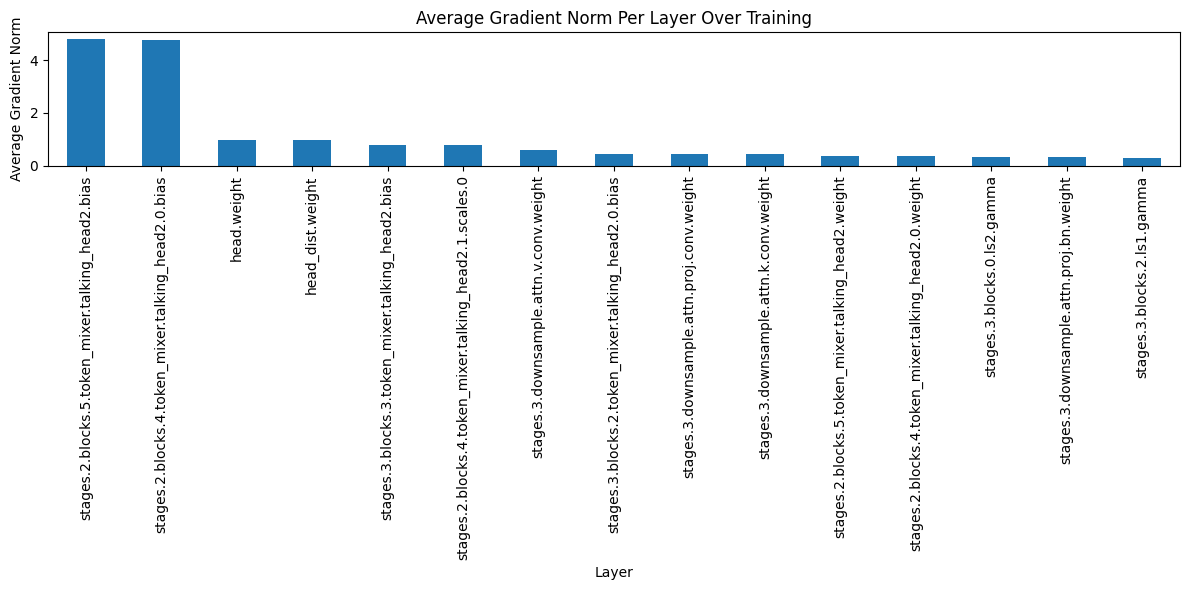

In [7]:
from matplotlib import pyplot as plt
import pandas as pd
grad_df = pd.read_csv("birds_grad_norm_per_layer.csv", index_col="epoch")

avg_norms = grad_df.mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
avg_norms.plot(kind='bar')
plt.ylabel("Average Gradient Norm")
plt.xlabel("Layer")
plt.title("Average Gradient Norm Per Layer Over Training")
plt.tight_layout()
plt.show()

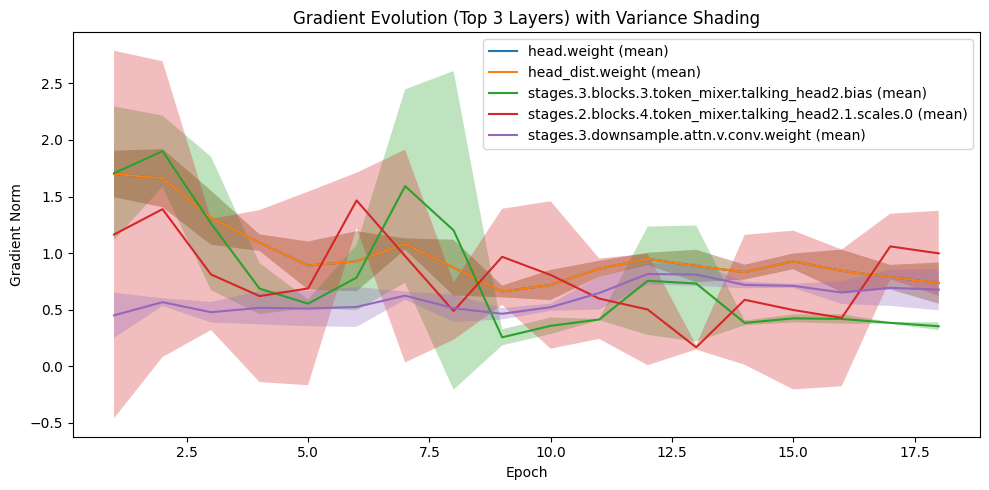

In [8]:
plt.figure(figsize=(10, 5))

top3_layers = avg_norms[2:].head(5).index

for layer in top3_layers:
    vals = grad_df[layer]
    mean = vals.rolling(2).mean()
    std = vals.rolling(2).std()

    plt.plot(vals.index, mean, label=f"{layer} (mean)")
    plt.fill_between(vals.index, mean-std, mean+std, alpha=0.3)

plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Evolution (Top 3 Layers) with Variance Shading")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
from matplotlib import pyplot as plt
import pandas as pd
grad_df = pd.read_csv("birds_mvit_grad_norm_per_layer.csv", index_col="epoch")

avg_norms = grad_df.mean().sort_values(ascending=False).head(15)


In [10]:
# mvit
avg_norms

head.fc.weight                                           0.673099
stages.3.1.transformer.0.attn.out_proj.1.blocks.0.1.W    0.434496
stages.3.1.transformer.0.attn.out_proj.1.blocks.0.0.W    0.375130
stages.4.1.conv_proj.bn.bias                             0.325048
stages.3.1.transformer.1.attn.out_proj.1.blocks.0.1.W    0.283419
stages.3.1.transformer.1.attn.out_proj.1.blocks.0.0.W    0.278130
head.fc.bias                                             0.231209
stages.3.1.transformer.0.attn.out_proj.0.weight          0.228948
stages.3.1.transformer.1.attn.out_proj.0.weight          0.227496
stages.3.1.transformer.0.norm1.weight                    0.219294
stages.3.0.conv1_1x1.conv.weight                         0.215831
stages.3.1.transformer.0.attn.qkv_proj.weight            0.173243
stages.3.1.transformer.1.attn.qkv_proj.weight            0.172632
stages.3.1.transformer.1.norm1.weight                    0.160911
stages.3.1.transformer.0.norm1.bias                      0.151307
dtype: flo

In [13]:
# eformer
avg_norms

stages.2.blocks.5.token_mixer.talking_head2.bias          4.825051
stages.2.blocks.4.token_mixer.talking_head2.0.bias        4.770374
head.weight                                               0.990715
head_dist.weight                                          0.990715
stages.3.blocks.3.token_mixer.talking_head2.bias          0.788289
stages.2.blocks.4.token_mixer.talking_head2.1.scales.0    0.767982
stages.3.downsample.attn.v.conv.weight                    0.596412
stages.3.blocks.2.token_mixer.talking_head2.0.bias        0.449575
stages.3.downsample.attn.proj.conv.weight                 0.440458
stages.3.downsample.attn.k.conv.weight                    0.431548
stages.2.blocks.5.token_mixer.talking_head2.weight        0.364020
stages.2.blocks.4.token_mixer.talking_head2.0.weight      0.358401
stages.3.blocks.0.ls2.gamma                               0.344179
stages.3.downsample.attn.proj.bn.weight                   0.308017
stages.3.blocks.2.ls1.gamma                               0.30

In [1]:
!mkdir -p /scr/emazuh_data && tar xC /scr/emazuh_data -f /gscratch/scrubbed/emazuh/birds/files/ssw60/birds_inat.tar

In [1]:
# TODO: separate to a new notebook for gate logging
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.insert(0, '../..')
# sys.path.insert(0, '../../../../HyViT-MoE/')
import optuna
from hpo.objective import objective_mlp
from configs.adapter_config import AdapterConfig
from training.logging import log_optuna_importance_to_wandb

/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [3]:
adapter_cfg = AdapterConfig(
        place_on="mlp",
        layer_mode="all",
    )
objective_mlp(
            trial=None,
            epochs=10,#2,
            model_name="mobilevit", # "efficientformer", # "mobilevit",
            dataset_name="birds_inat",
            data_subset=0.1, #0.05, # 0.25, # 0.1
            adapter_cfg=adapter_cfg,
            log_wandb=True,
            chain_type="par_input",#"par_fixed",
            ds_grad_norm_file=None,# 'birds_grad_norm_per_layer.csv',
        )

[INFO]: Using dataset data/birds_inat
args Namespace(n_vid_frames=8, n_train_frames=2, visualization=False, double_view_image=False, k_shot=-1, evaluate=False, test=False, log_wandb=True, val_samples_per_class=5, max_grad_norm=10.0, eval_transform=False, num_workers=6, from_custom_pretrained=False, apply_entropy_to_val=True, ds_grad_norm_file=None, data_path='data/birds_inat', data_subset=0.1, vision_model='mobilevit', randerase_p=0.25825040732523524, batch_size=16, classes=60, transform_simple=Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    RandomErasing(p=0.25825040732523524, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=random, inplace=False)
), test_loader=<torch.utils.data.dataloader.DataLoader object at 0x15271069eb90>, num_classes=60)


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


entropy/train_ent,▁█
lr,▁▅██
train_acc,▁▄▆█
train_loss,█▆▂▁
val_subset_acc,▁▇█
val_subset_loss,█▂▁
entropy/train_ent,0.00094
lr,0.00599
train_acc,0.16389
train_loss,3.27305
val_subset_acc,0.15444


[INFO]: Using ChainParallelInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainParallelInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainParallelInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainParallelInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainParallelInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainParallelInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainParallelInputDependent
[INFO]: Using conv adapter experts
total_params  1482328


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 | Loss: 4.0946 | Acc: 0.018
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 4.0943 | Acc: 0.014


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/10 | Loss: 3.8426 | Acc: 0.075
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 3.3966 | Acc: 0.135
[INFO] Unfreezing adapters at epoch 2


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/10 | Loss: 3.3889 | Acc: 0.135
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 3.3995 | Acc: 0.140


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/10 | Loss: 3.2429 | Acc: 0.166
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 3.3504 | Acc: 0.162


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/10 | Loss: 3.2926 | Acc: 0.172
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 3.3264 | Acc: 0.151


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/10 | Loss: 2.9753 | Acc: 0.222
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 2.9694 | Acc: 0.241


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/10 | Loss: 2.5301 | Acc: 0.340
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 2.6972 | Acc: 0.293


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/10 | Loss: 2.2034 | Acc: 0.403
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 2.5302 | Acc: 0.341


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/10 | Loss: 2.0136 | Acc: 0.465
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 2.4279 | Acc: 0.369


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/10 | Loss: 1.9122 | Acc: 0.508
gate_outputs 1
calling log_to_wandb
Validation (subset) | Loss: 2.4351 | Acc: 0.373


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Full Validation | Loss: 2.4351 | Acc: 0.373
total_params 1482328


(0.37305555555555553, 1482328)

In [2]:
sds

NameError: name 'sds' is not defined